In [304]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

# the following commands make plots look better
def plot_prettier(dpi=200, fontsize=10, usetex=False): 
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    # if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    plt.rc('text', usetex=usetex)
    
plot_prettier()

In [7]:
#zCMB, mB, emB are redshift of SNia, its apparent B-band magnitude, and emB is its error
# x1 and ex1 are stretch parameter measured for each SN and its uncertainty
# csn and ecsn are color parameter and its uncertainty
zCMB, mB, emB, x1, ex1, csn, ecsn = np.loadtxt('https://astro.uchicago.edu/~andrey/classes/a211/data/jla_lcparams.txt', 
                                               usecols=(1, 4, 5, 6, 7, 8, 9), unpack=True)

print("read sample of %d supernovae..."%(np.size(zCMB)))

read sample of 740 supernovae...


In [14]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_tilde_astropy(z, H0, Om0, OmL, clight=2.99792e5):
    '''
    compute d_l_tilde using AstroPy d_L function
    
    Parameters:
    
    z - float, or numpy array, redshift
    H0 - float, Hubble constant in km/s/Mpc
    Om0, OmL - floats, dimensionless matter and dark energy densities
    
    Returns:
    
        d_L - float, or numpy array, rescaled by c/H0 in Mpc 
    '''
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    
    return cosmo.luminosity_distance(z=z) / u.Mpc / (clight/H0)

In [35]:
def chebyshev_nodes2(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos(np.arange(N+1)*np.pi/N))

def get_dl_train_test(ntrain=15, ntest=100, z=1.0, H0=70., 
                      om0min=0., om0max = 1., omlmin=0., omlmax=1.):
    '''
    Generate a grid of training values of d_L for a given redshift z, H0, and range
    of Om0 and OmL for specified number of training points and their spacing
    
    Parameters:
        ntrain - int, number of training points
        ntest - int, number of test points
        z - float, redshift for which to compute d_L_tilde values
        H0 - float, Hubble constant in km/s/Mpc
        om0min, om0max - floats, range of Omega_m0 values for which to generate training and test values
        omlmin, omlmax - floats, range of Omega_Lambda values 
                
    Returns:
        om0tr, omltr - 1d numpy arrays of floats, training points
        om0t, omlt   - 1d numpy arrays of floats, test points 
        dl_train, dl_test - 2d arrays of training and test values of d_L_tilde
    '''
    om0tr = sorted(chebyshev_nodes2(om0min, om0max, (ntrain-1)))
    omltr = sorted(chebyshev_nodes2(omlmin, omlmax, (ntrain-1)))
        
    dl_train = np.zeros((ntrain, ntrain)) # initialize 2D numpy array for 2D grid of d_L values     
    # Now cycle through Om0 and OmL values, compute d_L and fill the dlgrid array with values
    for i, omd in enumerate(om0tr):
        for j, omld in enumerate(omltr):
                dl_train[i,j] = d_l_tilde_astropy(z, H0, omd, omld)

    # test points             
    om0t = np.linspace(om0min, om0max, ntest)
    omlt = np.linspace(omlmin, omlmax, ntest)

    dl_test = np.zeros((ntest, ntest)) # initialize 2D numpy array for 2D grid of d_L values 
    # Now cycle through Om0 and OmL values, compute d_L and fill the dlgrid array with values
    for i, omd in enumerate(om0t):
        for j, omld in enumerate(omlt):
                dl_test[i,j] = d_l_tilde_astropy(z, H0, omd, omld)

    return om0tr, omltr, om0t, omlt, dl_train, dl_test

In [36]:
from scipy.interpolate import RectBivariateSpline



def approxdl(z):
    ans = []
    
    for i in range(len(z)):
        om0tr, omltr, om0t, omlt, dl_train, dl_test = get_dl_train_test(ntrain=18, ntest=0, z=z[i], H0=70., 
                      om0min=0., om0max = 1., omlmin=0., omlmax=1.)
        
        
        ans.append(RectBivariateSpline(om0tr, omltr, dl_train, s=0, kx=3, ky=3))
        
    return ans


    

In [152]:
  an = approxdl(zCMB)
for i in range(10):
    rand = np.random.randint(0, 80)
    real = d_l_tilde_astropy(zCMB,70,0.5,0.5)
    an1 = an[rand](0.5,0.5)
    re1 = real[rand]
    print(an1)
    print(re1)


[[0.98809012]]
0.9880902477406305
[[False]]
[[0.5525698]]
0.5525698194628126
[[False]]
[[0.98809012]]
0.9880902477406305
[[False]]
[[0.96935765]]
0.9693577730392102
[[False]]
[[1.03545272]]
1.0354528732636896
[[False]]
[[0.82282334]]
0.8228234090042678
[[False]]
[[0.98279734]]
0.9827974697012918
[[False]]
[[1.22599897]]
1.2259992235508712
[[False]]
[[0.64082864]]
0.6408286689840097
[[False]]
[[0.50406662]]
0.5040666345615226
[[False]]


In [153]:
def minimize_de_v(func, x0, atol=1.e-6, cr=0.7, tol=0.01, s=0.1, args=[], 
                               crossover=True, bounds=None, verbose=False):
    """
    fully vectorized version of the Differential Evolution method 
    
    """
    assert(atol > 0.)
    npop, nd = np.shape(x0)
    xnow = np.copy(x0.T)
    xnext = np.zeros_like(xnow)
    dxmax = 100.*atol

    # initialize array of sequences that do not include i
    ir = np.zeros((npop, npop-1)).astype(int)
    for i in range(npop):
        ir[i,:] = np.random.permutation(np.hstack((np.arange(i),np.arange(i+1,npop))))
   
    fnow = func(xnow, *args)    
    fnext = np.zeros_like(fnow)

    jdim = np.zeros((nd,npop))
    for i in range(npop):
        jdim[:,i] = np.arange(nd)
        
    sqrts = np.sqrt(s)
    initind = np.arange(npop)

    converged = False
    
    left_bounds = np.tile(bounds.T[0], (npop,1)).T
    right_bounds = np.tile(bounds.T[1], (npop,1)).T
    
    niter = 0 
    while not converged or dxmax == 0:
        niter += 1
        xnext = np.copy(xnow)
        sr = np.random.uniform(s, np.minimum(1.+s,2.), size=npop)
        
        # the following 3 lines implement the 2nd part of crossover, 
        # but I found that this part doesn't make much difference but slows down calculation  
        #iri = np.random.randint(0, nd, size=npop*nd).reshape(nd,npop)
        #icr2 = ~(jdim - iri).astype('bool')
        #icr = np.logical_or(icr1,icr2)
        # shuffle indices 
        np.random.shuffle(ir.T)
        # trial step
        xtry = xnow[:,ir[:,0]] + np.multiply(np.tile(sr,(nd,1)), (xnow[:,ir[:,1]] - xnow[:,ir[:,2]]))
        # crossover
        if crossover: 
            rj = np.random.uniform(size=npop*nd).reshape(nd,npop)
            icr = rj > cr
            xtry[icr] = xnow[icr] 
            
        ftry = func(xtry, *args)
        iaccf = (ftry <= fnow)
        iaccx = np.tile(iaccf, (nd,1)) & (xtry >= left_bounds) & (xtry <= right_bounds)
        xnext[iaccx] = xtry[iaccx]
        fnow = func(xnext, *args)
        dxmax = np.abs(xnext - xnow).max()
        converged = (dxmax < atol).all()
        # this is an alternative convergence indicator similar to what's used in scipy.optimize.differential_evolution
        #converged = (np.std(fnow, ddof=1) <= atol + tol * np.abs(np.mean(fnow))).all()
        xnow = np.copy(xnext)
        
        if verbose:
            print(xnext[0], dxmax)
            
    x_min = np.median(xnow, axis=1)
    print('DE finished with {:d} function evaluations'.format(niter*2))
    return x_min

In [332]:
def lFunc(x, *args):
    approx, mB, emB, x1, ex1, csn, ecsn = args
    sum1 = 0
    for i in range(739):
        delMu = mB[i] - 5*np.log10(float(approx[i](x[0], x[1]))) - x[2] + x[3]*x1[i] - x[4]*csn[i]
        sigDel = (emB[i]**2+(x[3]*ex1[i])**2+(x[4]**ecsn[i])**2)
        sum1 += -(1/2)*delMu**2/(sigDel) - (1/2)*np.log(2*np.pi*sigDel)
 
    return -sum1
    
    

In [155]:
import scipy
def optL():
    bounds = [[0,1], [0,1], [20, 28], [0.05, 0.3], [1, 5]]
    npop = 15
    s=0.5
    args = an, mB, emB, x1, ex1, csn, ecsn
    m = scipy.optimize.differential_evolution(lFunc, bounds=bounds, args=args)
    
    return m

In [156]:
ans = optL()
print(ans)

<class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
     fun: 704.3836325778552
     jac: array([-3.44471118e-03,  1.72803993e-03, -8.07176481e-04, -5.47970558e-03,
        4.74849119e+01])
 message: 'Optimization terminated successfully.'
    nfev: 1182
     nit: 13
 success: True
       x: array([ 0.23754168,  0.35183908, 24.09344435,  0.09022364,  1.        ])


a = 1 / $\int^{\infty}_{-\infty}\sqrt{x} = 1 / (2*(\sqrt{a} - \sqrt{1/a})) $

p(x) = $\int^{x}_{-\infty}A\sqrt{x} = \frac {(\sqrt{x} - \sqrt{1/a})} {(\sqrt{a} - \sqrt{1/a})} $

$p^{-1}(y)= y^2 * a * (\sqrt{a} - \sqrt{1/a})^2$

In [272]:
def pdf(x):
    return (1/(2*(np.sqrt(2)-np.sqrt(1/2))* np.sqrt(x)))

def inCdf(y):
    return (y*(np.sqrt(2)-np.sqrt(1/2)) + 1/np.sqrt(2))**2


In [273]:
def plot_pdf(xr, plot_pdf=True, func=None, args=None,
             xlabel='$x$', ylabel='$p(x)$',  label='samples', 
             bins = 50, xlog=False, ylog=True, 
             xlims=[0.,30.], ylims=[1.e-6, 0.4], figsize=5):
    """
    a utility function to plot samples from a pdf as a histogram and compare
    the histogram to the analytical form of the pdf plotted as a line, if needed
    
    Parameters:
    -----------
    xr:           1d numpy array of float numbers: vector of samples
    plot_pdf:     boolean, determines whether to plot a line of the target pdf
                  if True, func needs to be supplied
    func:         Python function object: function that returns analytic pdf for a given vector xr
    args:         list of possible arguments to func, if any
    xlabel, ylabel: strings, labels for x and y axes
    label:        string, label for the samples histogram for the legend
    bins:         integer or string (e.g., 'auto'), passed on as bins parameter to Pylab's histogram function
    xlog, ylog:   boolean, determine whether x or y axis is to be plotted on logarithmic scale
    xlims, ylims: lists of 2 float elements defining plot limits for x and y axes
    figsize:      float, parameter controlling plot size 
    
    Returns:
    --------
    Nada
    """
    plt.figure(figsize=(figsize,figsize))
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    if xlog: plt.xscale('log') # plot y-values on a logarithmic scale
    if ylog: plt.yscale('log') # plot y-values on a logarithmic scale
    plt.xlim(xlims); plt.ylim(ylims) # set axis limits 

    # compute histogram values; 
    # density='True' normalizes histogram properly so it can be compared to pdf
    hist, bins, patches = plt.hist(xr, density=True, color='slateblue', bins=bins, label=label)
    # compute bin centers using numpy slicing 
    binc = 0.5*(bins[1:] + bins[:-1])
    if plot_pdf: 
        plt.plot(binc, func(binc, *args), lw=1.25, c='orangered', label='target pdf')
    plt.ylabel(r'$p(x)$') # label axis 
    plt.xlabel(r'$x$')
    plt.legend(loc='best', frameon=False, fontsize=3*figsize)
    plt.show()

In [274]:
ynrd = np.random.uniform(0,1,1000000)
xexp = inPdf(ynrd)
print(np.max(xexp))

1.999998966852159


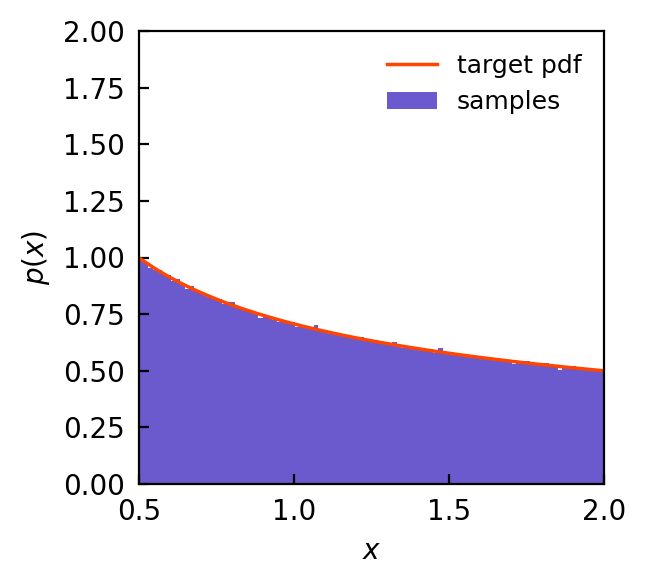

In [275]:
plot_pdf(xexp, func=pdf, args=[], xlims=[0.5,2], ylims=[0,2], 
         bins='auto', ylog = False, xlabel=r'$x$', ylabel=r'$p(x)$', figsize=3, )

In [367]:
def mcmc_gw10(p0, logpdf = None, args = None, nsteps=10000):
    nwalkers,ndim = p0.shape
    chain = [] 
    for nstep in range(nsteps):
        newWalker = np.zeros_like(p0)
        for i in range(nwalkers):
            x = p0[i]
            inds = np.arange(0,nwalkers) 
            inds = np.delete(inds,i) 
            np.random.shuffle(inds)
            zr = inCdf(np.random.uniform(0, 1))
            xtry = p0[inds[0]] + zr*(x-p0[inds[0]])

            ftry = logpdf(xtry, *args)
            lnP = np.log(zr**(ndim-1)) + ftry - logpdf(x,*args)
            lnU = np.log(np.random.uniform(0,1))
            if lnP > lnU:
                x = xtry
                fnow = ftry
            else: 
                x = p0[i]
            newWalker[i] = x
        chain.append(newWalker)
        p0 = newWalker
    
    return np.array(chain)
  

In [328]:
def lngauss_nd(x, means, icov):
    """
    ln of N-dimensional unnormalized Gaussian pdf (neglecting the constant in front of exp)
    
    Parameters:
    -----------
    x - real 1d numpy vector of size ndim
        position of a sample in ndim-dimensional space
    means - real 1d numpy vector of size ndim
        mean values of the Gaussian in each coordinate
    icov - numpy array of floats of shape (ndim, ndim)
        inverse covariance matrix of the Gaussian
        
    Returns:
    --------
    
    a real number 
        ln(Gaussian)
    """
    diff = x - means
    
    return -0.5 * np.dot(diff.T, np.dot(icov, diff)) 

In [329]:
# define st deviations for the two dimension of the Gaussian and value of correlation coefficient
means = [0., 0.] # values of means of Gaussian pdf for 2 dimensions
s1, s2, r = 1.0, 1.0, 0.95

# covariance matrix of 2-dimensional Gaussian
cov = [[s1**2, r*s1*s2], [r*s1*s2, s2**2]]
# compute the inverse covariance matrix
icov = np.linalg.inv(cov)
args = [means, icov]

In [368]:
import emcee

ndim, nwalkers, nsteps = 2, 50, 10000

# initialize walkers around best fit parameter values
p0 = np.zeros(((nwalkers, ndim)))
for d in range(ndim): 
    # generate Gaussian random numbers 
    # 0.05 is a small dispersion around the mean. The exact value does not matter
    p0[:,d] = 0.05*np.random.normal(size=nwalkers)
    
# create an instance of the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim,  lngauss_nd, args=args)

# run for a given nsteps
dummy = sampler.run_mcmc(p0, nsteps)

# get chain
chain = np.array(sampler.chain)
chain2 = mcmc_gw10(p0, logpdf = lngauss_nd, args = args, nsteps = nsteps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073


3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792


5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536


7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241


8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957


In [369]:
chain2.shape # shape is (nwalkers, nsteps, ndim)

(10000, 50, 2)

In [370]:
def plot_2d_dist(x,y, xlim, ylim, nxbins, nybins, figsize=(5,5), 
                cmin=1.e-4, cmax=1.0, smooth=None, xpmax=None, ypmax=None, 
                log=False, weights=None, xlabel='x', ylabel='y', 
                clevs=None, fig_setup=None, savefig=None):
    """
    construct and plot a binned, 2d distribution in the x-y plane 
    using nxbins and nybins in x- and y- direction, respectively
    
    log = specifies whether logged quantities are passed to be plotted on log-scale outside this routine
    """
    if fig_setup is None:
        fig, ax = plt.subplots(figsize=figsize)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
    else:
        ax = fig_setup
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim); ax.set_ylim(ylim)

    if xlim[1] < 0.: ax.invert_xaxis()

    if weights is None: weights = np.ones_like(x)
    H, xbins, ybins = np.histogram2d(x, y, weights=weights, bins=(np.linspace(xlim[0], xlim[1], nxbins),np.linspace(ylim[0], ylim[1], nybins)))
    
    H = np.rot90(H); H = np.flipud(H); 
             
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 

    if smooth != None:
        from scipy.signal import wiener
        H = wiener(H, mysize=smooth)
        
    H = H/np.sum(H)        
    Hmask = np.ma.masked_where(H==0,H)
    
    if log:
        X = np.power(10.,X); Y = np.power(10.,Y)

    pcol = ax.pcolormesh(X, Y,(Hmask),  cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True)
    pcol.set_edgecolor('face')
    
    # plot contours if contour levels are specified in clevs 
    if clevs is not None:
        lvls = []
        for cld in clevs:  
            sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )   
            lvls.append(sig)
        
        ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls), 
                norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])
    if xpmax is not None:
        ax.scatter(xpmax, ypmax, marker='x', c='orangered', s=20)
    if savefig:
        plt.savefig(savefig,bbox_inches='tight')
    if fig_setup is None:
        plt.show()
    return

In [371]:
import scipy.optimize as opt
from matplotlib.colors import LogNorm

In [372]:
def conf_interval(x, pdf, conf_level):
    return np.sum(pdf[pdf > x])-conf_level

/var/folders/2j/_zfm4bxj0cl90wmtwhzby29h0000gn/T/ipykernel_10343/4284644973.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcol = ax.pcolormesh(X, Y,(Hmask),  cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True)
/var/folders/2j/_zfm4bxj0cl90wmtwhzby29h0000gn/T/ipykernel_10343/4284644973.py:52: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls),


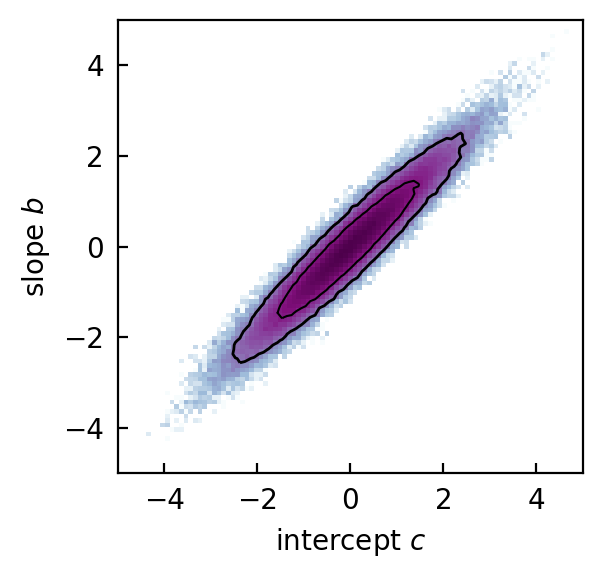

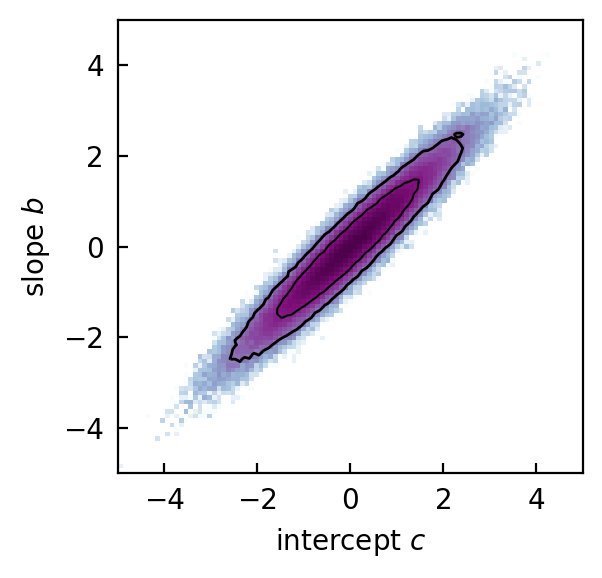

In [373]:
conflevs = [0.6827, 0.9545]

x = chain[:,:,0].flatten()
y = chain[:,:,1].flatten()


x2 = chain2[:,:,0].flatten()
y2 = chain2[:,:,1].flatten()


plot_2d_dist(x, y, xlim=[-5, 5], ylim =[-5,5], 
             nxbins=100, nybins=100, 
             clevs=conflevs, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

plot_2d_dist(x2, y2, xlim=[-5, 5], ylim =[-5,5], 
             nxbins=100, nybins=100, 
             clevs=conflevs, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

#### <font color='darkblue'> Task 4c (7 points)</font>

Write a function that defines natural logarithm of prior pdf for all parameters $\ln p$. Write another function that defines unnormalized posterior pdf, i.e. combines $\ln L$ (from ex 2 aove) and $\ln p$ into $\ln L(\mathbf{y}\vert\mathbf{x}) + \ln p(\mathbf{x})=\ln L(\mathbf{y}\vert\mathbf{x})p(\mathbf{x})$. For $p$ for all parameters you can assume uniform pdf defined between minimum and maximum value you choose for each parameter (these should be $0$ and $1$ for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ not to extrapolate your approximation for $\tilde{d}_L$. The total $\ln$ of prior pdf for all parameters is a sun of $\ln$ prior pdfs for individual parameters.

* Use your implementation of GW10 or <tt>emcee</tt> package to sample $\ln L(\mathbf{y}\vert\mathbf{x})p(\mathbf{x})$ using GW10 MCMC, initializing "walker" positions around the values of the best fit parameters you obtained in ex 2 above. 

* Plot resulting distributions of chain values for $\Omega_{\rm m0}$ and $\Omega_\Lambda$ along with the confidence contours that correspond to $1-$ and $2-\sigma$ of the Gaussian distribution and enclose $0.6827$ and $0.9545$. 

* Use examples in [<tt>11_mcmc_stat_models</tt>](https://drive.google.com/file/d/1ksi7VjA48PutOS7TJ17FS5H2Ve0qmjv2/view?usp=sharing) notebook (for example, function <tt>chain_stats</tt> to output statistics about $\Omega_{\rm m0}$ and $\Omega_\Lambda$) to output statistics of these quantities.

***Note:*** If you don't manage to complete your implementation of GW10, you can use <tt>emcee</tt> package, using example shown above, to complete this exercise. 

In [385]:
def logPriorPdf(x, bounds):
    if ((bounds[:,0]<x).all()) and ((bounds[:,1]>x).all()):
        return 0
    else:
        return -10000
    
def newPDF(x, *args):
    bound = np.array([[0,1], [0,1], [20, 28], [0.05, 0.3], [1, 5]])
    return lFunc(x, *args) + logPriorPdf(x, bound)


ndim, nwalkers, nsteps = 5, 10, 1000

args2 = an, mB, emB, x1, ex1, csn, ecsn

# initialize walkers around best fit parameter values
p0 = np.zeros(((nwalkers, ndim)))
for d in range(ndim): 
    # generate Gaussian random numbers 
    # 0.05 is a small dispersion around the mean. The exact value does not matter
    p0[:,d] = ans.x[d]+0.002*np.random.normal(size=nwalkers)

print(p0)
chain3 = mcmc_gw10(p0, logpdf = newPDF, args = args2, nsteps = nsteps)
    

[[ 0.23742204  0.35162621 24.09298338  0.09530915  0.99867063]
 [ 0.23491245  0.35276337 24.09383758  0.09370014  1.00122232]
 [ 0.23740158  0.35345028 24.09295113  0.09288557  1.00265961]
 [ 0.23902884  0.35158333 24.09313437  0.09204733  1.00173905]
 [ 0.23778116  0.35659938 24.09538481  0.08925881  0.99791113]
 [ 0.24396956  0.35042105 24.09439642  0.08841631  1.00118056]
 [ 0.24149489  0.34937932 24.0941254   0.08932108  1.00079728]
 [ 0.23742405  0.35385918 24.08931611  0.09340665  0.99978977]
 [ 0.23764473  0.35004011 24.09739533  0.09318309  1.0037289 ]
 [ 0.23623016  0.35467922 24.0901078   0.09187657  0.99771641]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


/var/folders/2j/_zfm4bxj0cl90wmtwhzby29h0000gn/T/ipykernel_10343/3240249951.py:6: RuntimeWarning: invalid value encountered in double_scalars
  sigDel = (emB[i]**2+(x[3]*ex1[i])**2+(x[4]**ecsn[i])**2)


23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
2

In [386]:
x3 = chain3[:,:,0].flatten()
y3 = chain3[:,:,1].flatten()
print(chain3.shape)
print(np.max(x3),np.min(x3))
print(np.max(y3),np.min(y3))

(1000, 10, 5)
0.9999947498305091 -0.1407205390747682
1.046738695941709 4.604666203033778e-06


/var/folders/2j/_zfm4bxj0cl90wmtwhzby29h0000gn/T/ipykernel_10343/4284644973.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcol = ax.pcolormesh(X, Y,(Hmask),  cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True)
/var/folders/2j/_zfm4bxj0cl90wmtwhzby29h0000gn/T/ipykernel_10343/4284644973.py:52: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls),


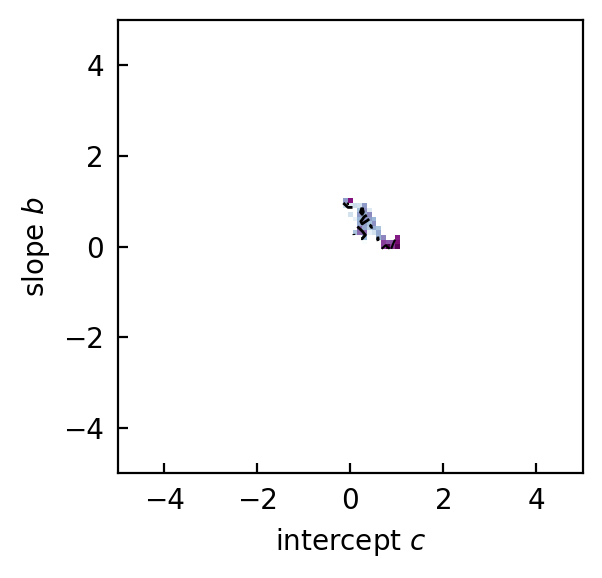

In [387]:
plot_2d_dist(x3, y3, xlim=[-5, 5], ylim =[-5,5], 
             nxbins=100, nybins=100, 
             clevs=conflevs, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

In [ ]:
2